In [12]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.sparse.linalg as splinalg
import scipy.linalg as la
import time

In [13]:
# sparse matrix solver
def generate_the_laplace_matrix_with_size(N=128):
    """
    assume sqrt(N) is an integer. Generate the Laplace matrix with size N

    """
    nsq = N * N
    A = np.zeros((nsq, nsq))
    A = _kernel(N, nsq, A)
    
    return A
    
@numba.jit(nopython=True)
def _kernel(N, nsq, A):
    for i in range(nsq):
        for j in range(nsq):
            if i == j:
                A[i, j] = 4
            elif (i == j + N or i == j - N):
                A[i, j] = -1
            elif (i == j + 1 or i == j - 1):
                if (((i + 1) % N == 0 and (j % N == 0)) or ((i % N == 0 and ((j + 1) % N == 0)))) and i != 0 and j != 0:
                    A[i, j] = 0
                else:
                    A[i, j] = -1
            else:
                A[i, j] = 0

    return A

def generate_rho(N=128, xmin=-5, xmax=5, ymin=-5,ymax=5):
    # TODO:
    x = np.linspace(xmin, xmax, N)
    y = np.linspace(ymin, ymax, N)

    xx,yy  = np.meshgrid(x, y, indexing='ij')
    r1 = (xx + 1.5)**2 + yy**2
    r2 = (xx - 1.5)**2 + yy**2
    rho = np.exp(-5 / 4 * r1**2) + 3 / 2 * np.exp(-(r2**2))
    
    return xx, yy, rho

def generate_the_rhs_vector_with_size(rho):
    
    bb = rho.flatten()
    
    return bb

In [14]:
# Jacobi, Gauss-Seidel, SOR methods
def generate_mesh(nx, ny, buff=1, xmin=-5, xmax=5, ymin=-5, ymax=5):

    u = np.zeros((nx + 2 * buff, ny + 2 * buff))
    x = np.linspace(xmin, xmax, nx + 2 * buff)
    y = np.linspace(ymin, ymax, ny + 2 * buff)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    return u, x, y, dx, dy
   
@numba.jit(nopython=True)
def jacobi(u, uold, nx, ny, omega=None):
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            u[i,j] = 0.25 * (uold[i-1, j] + uold[i+1, j] + uold[i, j-1] + uold[i, j+1])
    return u

@numba.jit(nopython=True)
def GaussSeidel(u, _unused, nx, ny, omega=None):
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            u[i,j] = 0.25 * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1])
    return u

@numba.jit(nopython=True)
def SOR(u, uold, nx, ny, omega=1.2):
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            u[i,j] = (1 - omega) * uold[i,j] + omega * 0.25 * (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1])
    return u

def relax(u, method, tol=1e-6, maxiter=100_000, omega=1.2):
    err = np.zeros(maxiter)
    nx, ny = u.shape
    
    uold = u.copy()
    if method == 'jacobi':
        method = jacobi
    elif method == 'GaussSeidel':
        method = GaussSeidel
    elif method == 'SOR':
        method = SOR
    else:
        raise ValueError('Method not implemented')
    
    for i in range(maxiter):
        u = method(u, uold, nx, ny, omega)
        err[i] = np.linalg.norm(u - uold, np.inf)
        uold = np.copy(u)
        if err[i] < tol:
            break
    
    return u, i, err

In [15]:

N_list = [32, 64, 128]

tol = 1e-7
maxiter = 100_000

omega1 = 1.2
omega2 = 1.5

# sparse
t_sparse = np.zeros(3)
for i in range(3):
    t1 = time.time()
    A = generate_the_laplace_matrix_with_size(N_list[i])

    xx, yy, rho = generate_rho(N_list[i])
    b = generate_the_rhs_vector_with_size(rho)
    x = splinalg.spsolve(A, b)
    # x = x / la.norm(x)
    t2 = time.time()
    t_sparse[i] = t2 - t1

# Jacobi
t_jacobi = np.zeros(3)
for i in range(3):
    u, x, y, dx, dy = generate_mesh(N_list[i], N_list[i])
    u[0, :] = 0
    u[-1, :] = 0
    u[:, 0] = 0
    u[:, -1] = 0

    xx, yy, rho = generate_rho(N_list[i])
    u[1:-1, 1:-1] = rho
    u_1 = u.copy()
    
    t1 = time.time()
    u_jac, it, err = relax(u_1, 'jacobi', tol=tol, maxiter=maxiter)
    t2 = time.time()
    t_jacobi[i] = t2 - t1

# Gauss-Seidel
t_gs = np.zeros(3)  
for i in range(3):
    u, x, y, dx, dy = generate_mesh(N_list[i], N_list[i])
    u[0, :] = 0
    u[-1, :] = 0
    u[:, 0] = 0
    u[:, -1] = 0

    xx, yy, rho = generate_rho(N_list[i])
    u[1:-1, 1:-1] = rho
    u_1 = u.copy()
    
    t1 = time.time()
    u_gs, it, err = relax(u_1, 'GaussSeidel', tol=tol, maxiter=maxiter)
    t2 = time.time()
    t_gs[i] = t2 - t1

# SOR 1.2
t_sor1 = np.zeros(3)
for i in range(3):
    u, x, y, dx, dy = generate_mesh(N_list[i], N_list[i])
    u[0, :] = 0
    u[-1, :] = 0
    u[:, 0] = 0
    u[:, -1] = 0

    xx, yy, rho = generate_rho(N_list[i])
    u[1:-1, 1:-1] = rho
    u_1 = u.copy()
    
    t1 = time.time()
    u_sor1, it, err = relax(u_1, 'SOR', tol=tol, maxiter=maxiter, omega=omega1)
    t2 = time.time()
    t_sor1[i] = t2 - t1

# SOR 1.5
t_sor2 = np.zeros(3)
for i in range(3):
    u, x, y, dx, dy = generate_mesh(N_list[i], N_list[i])
    u[0, :] = 0
    u[-1, :] = 0
    u[:, 0] = 0
    u[:, -1] = 0

    xx, yy, rho = generate_rho(N_list[i])
    u[1:-1, 1:-1] = rho
    u_1 = u.copy()
    
    t1 = time.time()
    u_sor2, it, err = relax(u_1, 'SOR', tol=tol, maxiter=maxiter, omega=omega2)
    t2 = time.time()
    t_sor2[i] = t2 - t1
    

/var/folders/j1/hyd9nr6j5rj206vbv9nyjjcc0000gn/T/ipykernel_9129/394978937.py:17: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  x = splinalg.spsolve(A, b)


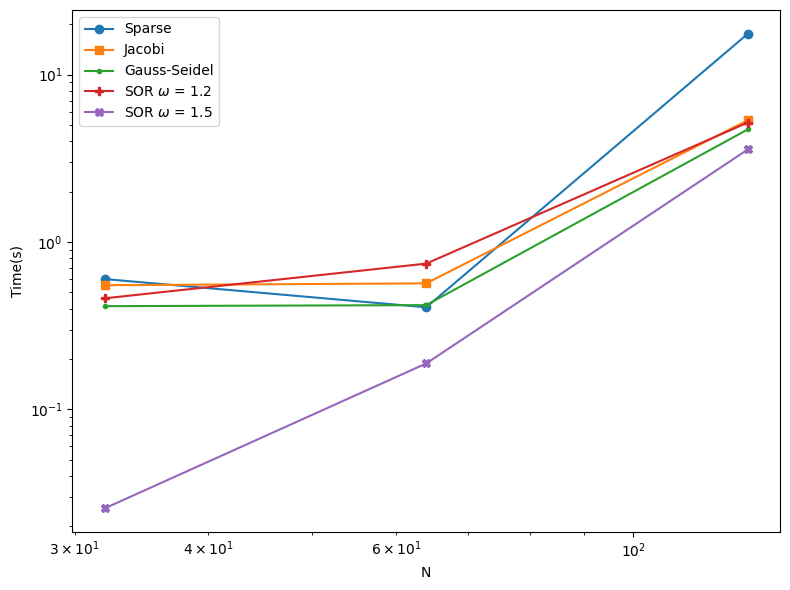

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(N_list, t_sparse, 'o-', label='Sparse')
plt.plot(N_list, t_jacobi, 's-', label='Jacobi')
plt.plot(N_list, t_gs, '.-', label='Gauss-Seidel')
plt.plot(N_list, t_sor1, 'P-', label=r'SOR $\omega$ = 1.2')
plt.plot(N_list, t_sor2, 'X-', label=r'SOR $\omega$ = 1.5')
plt.xlabel('N')
plt.ylabel('Time(s)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.title('Time vs N')
plt.tight_layout()
plt.savefig('time_N.png')
plt.show()

In [17]:
print('Sparse:', t_sparse)
print('Jacobi:', t_jacobi)
print('Gauss-Seidel:', t_gs)
print('SOR 1.2:', t_sor1)
print('SOR 1.5:', t_sor2)


Sparse: [ 0.60075092  0.40725398 17.55519009]
Jacobi: [0.55179214 0.5661397  5.34169602]
Gauss-Seidel: [0.41365194 0.41961288 4.70886493]
SOR 1.2: [0.46076488 0.74265075 5.17423368]
SOR 1.5: [0.02560592 0.1880641  3.57340097]
